## Data Transformation for NN
---

In [2]:
%%capture capt
!pip install lightgbm smart_open tqdm graphviz

In [3]:
import sys, os, json
import pandas as pd
import numpy as np
import lightgbm as lgb
import pickle as pkl
from tqdm import tqdm
from smart_open import open

sys.path.insert(1, "..")

import warnings
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 500)

%load_ext autoreload
%autoreload 2

In [4]:
with open(os.path.join("../config.json"), "r") as f:
    config = json.load(f)

In [5]:
train_df = pd.read_parquet(config["data_processed"]["train_df"])
valid_df = pd.read_parquet(config["data_processed"]["valid_df"])
test_df = pd.read_parquet(config["data_processed"]["test_df"])

In [6]:
dd = pd.read_csv(config["meta"]["data_dict_path"])

bureau_features = config["data_columns"]["bureau_features"]
meta_cols = config["data_columns"]["meta_cols"]
target_col = config["data_columns"]["target_cols"][0]
gen3_features = config["data_columns"]["gen3_features"]

features = gen3_features

In [6]:
from rdsutils.woe import WOE_Transform

In [7]:
woe = WOE_Transform()
woe.fit(train_df[features], train_df[target_col], display=-1)

processed  32  num attributes



In [8]:
def get_monotone_dir(woe_dict):
    result = {}
    for k in woe_dict:
        tbl = woe_dict[k]
        if tbl.iloc[0]["woe"] < tbl.iloc[1]["woe"]:
            direction = 1
        else:
            direction = -1
        
        result[k] = direction
    return result

In [9]:
monotone_dict = get_monotone_dir(woe.woe_dict())
mc_constraints = [monotone_dict[ft] for ft in features]

### Data Preprocessing for DL
---

In [10]:
from tqdm import tqdm
from src.utils.preprocess import get_lgbm_split_caps, append_transform_cols
from sklearn.model_selection import train_test_split

In [11]:
train_df.shape, valid_df.shape, test_df.shape

((103538, 38), (27764, 38), (24876, 38))

### LGBM Baseline

In [12]:
train_df[target_col].value_counts(dropna=False)

0.0    96282
1.0     7256
Name: target_dev, dtype: int64

In [13]:
# data imbalance
neg, pos = np.bincount(train_df[target_col])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))
pos_neg_ratio = pos/neg

Examples:
    Total: 103538
    Positive: 7256 (7.01% of total)



In [14]:
# load params used in gen3
s3_path = "s3://sofi-data-science/jxu/pl-gen4/data_dump/pl-gen3-final-data/"

# model params
with open(os.path.join(s3_path, "model_params.json"), "r") as f:
    params = json.load(f)

params["n_estimators"] = 800
params["monotone_constraints"] = mc_constraints
params["scale_pos_weight"] = 1/pos_neg_ratio


config["model_params"] = params

In [15]:
import lightgbm as lgb
from sklearn.metrics import average_precision_score, roc_auc_score

clf = lgb.LGBMClassifier(**params)  # (scale_pos_weight=pos_neg_ratio)
clf = clf.fit(train_df[features], train_df[target_col],
              eval_set=(valid_df[features], valid_df[target_col]))
test_df["lgbm_pred"] = clf.predict_proba(test_df[features])[:,1]

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=30

### Impute Missing

Let's impute using WOE transform by encode missing with the mean of the bin that is closest based on woe

In [16]:
from rdsutils.woe import WOE_Transform

In [17]:
%%time
woe = WOE_Transform(min_iv=-np.inf)
woe.fit(train_df[features], train_df[target_col].astype(int), display=-1)

processed  32  num attributes

CPU times: user 5.85 s, sys: 0 ns, total: 5.85 s
Wall time: 5.85 s


In [18]:
woe_dict = woe.woe_dict()
len(woe_dict)

32

In [19]:
def get_missing_impute_value(woe_table):
    """ if missing in woe_table.index
    return the mean of the bin closest to missing in terms of WOE
    """
    if "missing" not in woe_table.index:
        return None
    
    woe_table = woe_table.sort_values("woe")
    woe_table.sort_values("woe")
    woe_table["distance"] = (woe_table["woe"] - woe_table.loc["missing", "woe"]).abs()
    woe_table = woe_table.loc[woe_table.index != "missing"]
    closest_bin = woe_table.sort_values("distance").head(1)
    if closest_bin.min == -np.inf:
        return closest_bin.max
    elif closest_bin.max == np.inf:
        return closest_bin.min
    return closest_bin[["min", "max"]].values.mean()

In [20]:
f = "p13_bcc5620"
display(woe_dict[f])
display(get_missing_impute_value(woe_dict[f]))

,%accts,min,max,woe
0,0.82%,0.0,20.0,0.8046
1,1.85%,21.0,209.0,0.5281
2,2.95%,210.0,605.0,0.5185
3,6.81%,606.0,2037.0,0.4076
4,2.57%,2038.0,2749.0,0.3410
5,1.59%,2750.0,3206.0,0.2835
6,17.45%,3207.0,9586.0,0.2087
7,5.05%,9587.0,11828.0,0.1032
8,18.01%,11829.0,21494.0,0.0480
9,13.98%,21495.0,32529.0,-0.1787


407.5

In [21]:
impute_vals = {}
for f in tqdm(features):
    val = get_missing_impute_value(woe_dict[f])
    if val != None:
        impute_vals[f] = val
        woe_table = woe_dict[f]
        train_df[f].fillna(val, inplace=True)
        valid_df[f].fillna(val, inplace=True)
        test_df[f].fillna(val, inplace=True)

100%|██████████| 32/32 [00:00<00:00, 226.03it/s]


### Clipping

In [22]:
# let's just clip at (s2-1) and (sk-1  + 1) due to the crazines of tree splits
def clip_df(df, features, clip_tbl):
    """
    clip df by features with "lower" and "upper" values in clip_tbl
    """
    for f in tqdm(features):
        lower = clip_tbl.loc[f]["s2"]
        upper = clip_tbl.loc[f]["sk-1"]
        df[f].clip(lower-1, upper+1, inplace=True)
    return df

# clipping
clip_tbl = get_lgbm_split_caps(clf.booster_)
train_df = clip_df(train_df, clip_tbl.index, clip_tbl)

clip_tbl = get_lgbm_split_caps(clf.booster_)
valid_df = clip_df(valid_df, clip_tbl.index, clip_tbl)

clip_tbl = get_lgbm_split_caps(clf.booster_)
test_df = clip_df(test_df, clip_tbl.index, clip_tbl)

100%|██████████| 31/31 [00:00<00:00, 569.33it/s]


### Standardization

In [23]:
train_df, tfmrs = append_transform_cols(train_df, features)

for f in tqdm(features):
    valid_df[f"{f}_xf"] = tfmrs[f].transform(valid_df[f].values.reshape(-1,1))

for f in tqdm(features):
    test_df[f"{f}_xf"] = tfmrs[f].transform(test_df[f].values.reshape(-1,1))

100%|██████████| 32/32 [00:00<00:00, 346.27it/s]


In [24]:
features_xf = [f"{f}_xf" for f in features]

array([[<AxesSubplot:title={'center':'p13_bcc5620'}>,
        <AxesSubplot:title={'center':'p13_bcc5620_xf'}>]], dtype=object)

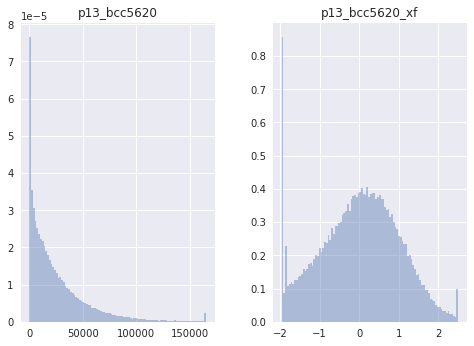

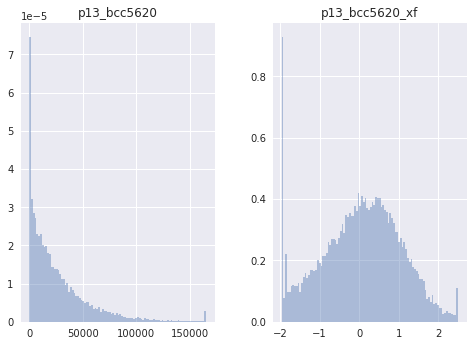

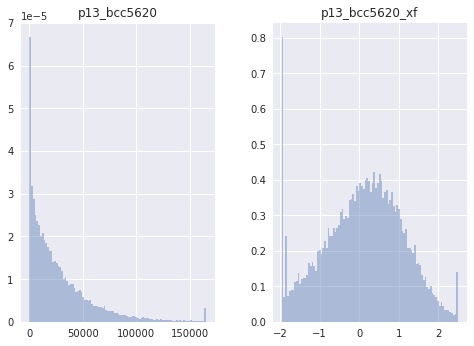

In [25]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")

f = "p13_bcc5620"  
train_df[[f, f+"_xf"]].hist(bins=100, density=True, alpha=0.4)
valid_df[[f, f+"_xf"]].hist(bins=100, density=True, alpha=0.4)
test_df[[f, f+"_xf"]].hist(bins=100, density=True, alpha=0.4)

In [26]:
train_df[features_xf].head()

,p13_bcc5620_xf,p13_rev5620_xf,p13_all7938_xf,p13_bcc8322_xf,p13_mtf4260_xf,p13_iqt9420_xf,p13_iqf9540_xf,p13_all7519_xf,p13_all8152_xf,p13_all4520_xf,...,p13_fip5020_xf,trended3d_tbcc2502_xf,trended3d_tbcc4502_xf,trended3d_tbca3275_xf,trended3d_tbca2618_xf,trended3d_tbcc3303_xf,trended3d_tbcc2303_xf,trended3d_tbcc3351_xf,trended3d_tbcc3502_xf,trended3d_tbcc4260_xf
1084,-0.716535,-0.556924,0.304442,1.389416,-0.67658,-1.037813,0.264073,-1.606223,0.609466,0.650364,...,0.435873,0.912943,0.708380,0.013609,1.512326,-0.112930,0.052794,0.968033,1.249868,1.226156
1091,0.633361,1.053952,0.304442,0.986294,-0.67658,-1.037813,0.264073,-1.606223,-1.789163,0.650364,...,0.435873,-0.603247,-0.814623,-1.472932,1.189435,0.190558,0.379846,-0.831298,-0.698166,-0.213710
1094,-0.133116,-0.342748,0.304442,0.922219,1.48078,-1.037813,0.264073,-1.140066,0.609466,0.650364,...,0.435873,-0.603247,-0.814623,-0.481119,0.159924,-0.293116,-0.129951,-0.366326,-0.698166,0.849353
1109,-0.070233,-0.353239,0.304442,-0.507288,-0.67658,-1.037813,0.264073,-0.775516,0.609466,0.650364,...,0.435873,-0.603247,-0.814623,-0.502501,-0.807336,-0.328419,-0.626126,0.460295,-0.698166,-0.043011
1119,-0.646656,-1.225763,0.304442,-1.397890,1.48078,0.967185,0.264073,1.746370,0.609466,0.532042,...,0.435873,-0.603247,-0.814623,-0.846304,0.159924,0.113901,0.052794,0.306760,-0.698166,1.996653


### Add target scaled weights

Currently data's weight should be only scaled by Reject inference. On top of the current weight, we should scale the positive (minority) class such that the total weight of the two classes are the same.

In [27]:
# total_weights = train_df.groupby(target_col)["weight"].sum()
# print("weights before: ")
# display(total_weights.round(2))

# # set a check statement here 
# assert(total_weights.loc[0] > total_weights.loc[1])
# scaling_factor = total_weights.loc[0] / total_weights.loc[1]
# train_df["target_scaled_weight"] = train_df["weight"] * np.where(train_df[target_col], scaling_factor, 1)

# print("rescaled_weights: ")
# display(train_df.groupby(target_col)["target_scaled_weight"].sum().round(2))

### Upload to S3

In [28]:
s3_path = config["meta"]["data_dir"]
if "data_processed" not in config:
    config["data_processed"] = {}

dpath = os.path.join(s3_path, "cleaned", "train_df_transformed.parquet")
train_df.to_parquet(dpath)
config["data_processed"]["xf_train_df"] = dpath

dpath = os.path.join(s3_path, "cleaned", "valid_df_transformed.parquet")
valid_df.to_parquet(dpath)
config["data_processed"]["xf_valid_df"] = dpath

dpath = os.path.join(s3_path, "cleaned", "test_df_transformed.parquet")
test_df.to_parquet(dpath)
config["data_processed"]["xf_test_df"] = dpath

In [29]:
with open(os.path.join("../config.json"), "w") as f:
    json.dump(config, f, indent=4)
    
with open(os.path.join(config["meta"]["data_dir"], "config.json"), "w") as f:
    json.dump(config, f, indent=4)